# AWESOME TOOL

## Data input

#### Imports

In [1]:
# Processing
from __future__ import division, print_function
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import timedelta
from scipy.optimize import curve_fit
from scipy.misc import factorial

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use = 'default' 
import mpld3

#### Data

In [2]:
files = ["../Data_Acetate/acetateAlarms.csv","../Data_Acetate/acetateAlarmsTr.csv"]

def GetData(files,systems=None):
    ''' Read the input data (one or more files, with the possibility to give the data from each file a (different) label). 
       Remove irrelevant entries (alarms being acknowledged or going off / alarms that are not really errors).
       Group the data by ID (ID's of which only one message was recorded, are left out).
       Add to each entry a field holding the time between this message and the previous one (in hours).
    '''
    # Read CSV data
    dfs = [pd.read_csv(f,encoding="utf-8-sig",parse_dates=['Timestamp']) for f in files]
    if systems and len(systems) == len(files):
        for i,x in enumerate(systems):
            dfs[i]['System'] = x
    df = pd.concat(dfs)

    # Remove irrelevant data
    if 'State' in df.columns:            # upcoming alarms (no OFF/ACK)
        df = df[df['State']==1]                                         
        del df['State']
    if 'Class' in df.columns:           # error messages (no System/Tolerance)
        df = df[df['Class']=='Error']
        del df['Class']  
    df.sort_values(by='Timestamp',inplace=True)    
    
    # Grouped data (by ID)
    dfs = {x: df[df['Id']==x].copy() for x in set(list(df['Id'])) if len(df[df['Id']==x]) > 1}    # get one dataframe per component ID
    
    # Add time interval data
    tmin = min(df['Timestamp']) - timedelta(seconds=2)
    tmax = max(df['Timestamp']) + timedelta(seconds=2)
    for key in list(dfs.keys()):
        dfs_prior = dfs[key][:2].copy()                             # add entry on first and last timestamp
        dfs_prior['Timestamp'] = [tmin,tmax]
        dfs[key] = pd.concat([dfs[key],dfs_prior])
        dfs[key].sort_values('Timestamp',inplace=True)                              # sort on timestamp
        dfs[key]['Delta'] = dfs[key]['Timestamp'] - dfs[key]['Timestamp'].shift(1)  # calculate time between
        dfs[key] = dfs[key][dfs[key]['Delta'].notnull()]
        dfs[key]['Delta'] = dfs[key]['Delta'].map(lambda x: x.days*24 + x.seconds//3600 + int((x.seconds%3600)/36)/100)
        dfs[key].index = range(len(dfs[key]))
    return dfs

dfs = GetData(files,["Acetate","Tracing"])
dfs_ids = sorted(list(dfs.keys()))
dfs[list(dfs.keys())[0]].head()

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


Timestamp                                            Message  \
0 2015-12-04 05:36:17  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
1 2015-12-04 05:36:47  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
2 2015-12-04 07:02:54  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
3 2015-12-15 04:10:25  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
4 2016-03-18 14:39:22  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   

                    Id   Type            Group   System    Delta  
0  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing   418.98  
1  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing     0.00  
2  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing     1.43  
3  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing   261.12  
4  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing  2266.48

## Data retrieval

#### Number Of Occurrences

In [3]:
def NumberOfOccurrences(data):
    ''' Count for each ID the number of occurrences. 
    '''
    return {x: data[x]['Message'].count() for x in data.keys()}    

dfs_noo = NumberOfOccurrences(dfs)

#### Number Of Messages

In [4]:
def NumberOfMessages(data):
    ''' Count for each ID the number of times each message occured per date. 
    ''' 
    ds = deepcopy(data)
    for key in list(ds.keys()):
        ds[key]['Timestamp'] = ds[key]['Timestamp'].map(lambda x: x.date())
        ds[key]['Count'] = ds[key]['Message'].map(lambda x: 1)
        ds[key] = ds[key][['Timestamp','Message','Count']]
        ds[key] = pd.pivot_table(ds[key],index=["Timestamp"],columns=["Message"],aggfunc=[np.sum])
    return ds

dfs_nom = NumberOfMessages(dfs)
dfs_nom[list(dfs.keys())[0]]

sum  \
                                                                                        Count   
Message    XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACING AZIJNZUUR PRODUCT LINES LAAG ALARM   
Timestamp                                                                                       
2015-12-04                                                2.0                                   
2015-12-15                                                1.0                                   
2016-03-18                                                1.0                                   
2016-04-02                                                2.0                                   
2016-04-03                                                1.0                                   
2016-04-13                                                NaN                                   

                                                                                                    
                                                                                                    
Message    XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACING AZIJNZUUR PRODUCT LINES LAAG LAAG ALARM  
Timestamp                                                                                           
2015-12-04                                                1.0                                       
2015-12-15                                                NaN                                       
2016-03-18                                                2.0                                       
2016-04-02                                                2.0                                       
2016-04-03                                                NaN                                       
2016-04-13                                                1.0

#### Poisson parameters

In [5]:
def Poisson(k, lamb):
    ''' Poisson distribution. 
    '''
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def PoissonParameters(data):
    ''' Fit a poisson distribution on the histogram of the data per ID and return the resulting poisson parameters.
    '''
    params = dict()
    for key in list(data.keys()):
        deltas = list(data[key]['Delta'])        
        bins = int(np.max(deltas) - np.min(deltas))
        #bins = 'auto'
        entries, bin_edges = np.histogram(deltas,bins=bins)  
        bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])  
        parameters, _ = curve_fit(Poisson, bin_middles, entries)
        params[key] = int(parameters[0]*1000)/1000  
    return params

dfs_pdp = PoissonParameters(dfs)

/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Tool

#### Create Tool

In [17]:
def Picker(event):
    ''' [callback function] Show detailed view when user clicks on a component in the scatter plot.
    '''
    ind = event.ind
    print('CLICK: ', ind, np.take(x, ind), np.take(y, ind))
    BarPlot()
    return


def ScatterPlot(data_x,data_y,data_l):
    ''' Show scatter plot with interactive artists. (hover = show label , click = show detailed view)
    '''
    mpld3.enable_notebook()
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
    scatter = ax.scatter(data_x,data_y)#,picker=True)
    #fig.canvas.mpl_connect('pick_event',Picker)
    ax.grid(color='white', linestyle='solid')
    ax.set_title("Scatter plot component ID's", size=20)
    
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=data_l)  
    mpld3.plugins.connect(fig, tooltip)
    return

#### Run it!

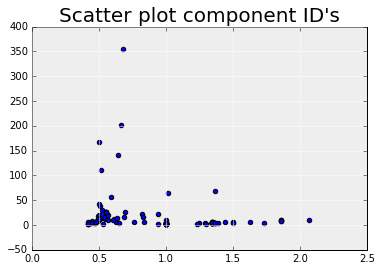

In [18]:
data_bar = [[x , dfs_pdp[x] , dfs_noo[x]] for x in dfs_ids]
data_sca = list(map(list, zip(*data_bar)))
ScatterPlot(data_sca[1],data_sca[2],data_sca[0])

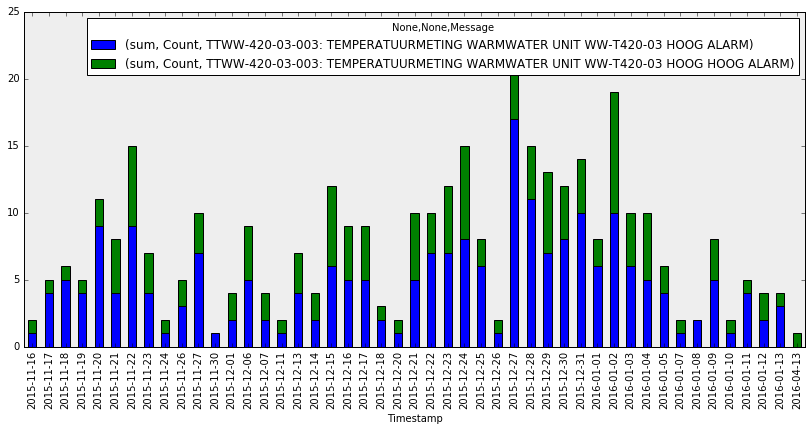

In [19]:
def BarPlot(label,data):
    ''' Show (stacked) bar plot of the number of occurences (of the different messages) of a component ID. 
    '''
    mpld3.disable_notebook()
    fig,ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(14, 6))
    
    ax.grid(color='white', linestyle='solid')
    data.plot.bar(ax=ax, stacked=True)
    plt.xticks(rotation='vertical')
    
    plt.show()
    mpld3.enable_notebook()
    return 

CLICK = 'TTWW-420-03-003'
BarPlot(data_bar[data_sca[0].index(CLICK)], dfs_nom[CLICK])

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
ScatterPlot([1,2,3], [0.5,1,1.5], ['One','Two','Three'])
#BarPlot()

In [ ]:
# SCATTER PLOT WITH TOOLTIPS
import matplotlib.pyplot as plt
import numpy as np
import mpld3

fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
N = 100

scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s=1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.show()

In [ ]:
# EVENT HANDLING PICK_EVENT
import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D
#from matplotlib.patches import Rectangle
#from matplotlib.text import Text
##from matplotlib.image import AxesImage
import numpy as np
from numpy.random import rand

x, y, c, s = rand(4, 100)

def onpick3(event):
    ind = event.ind
    print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))

fig, ax = plt.subplots()
col = ax.scatter(x, y, 100*s, c, picker=True)
#fig.savefig('pscoll.eps')
fig.canvas.mpl_connect('pick_event', onpick3)

plt.show()

In [ ]:
import matplotlib
%matplotlib inline
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import mpld3

def onclick(event):
    print('Test')

#fig = plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
parameter_values = [1,2,3,4]
#axis = fig.add_subplot(211)
ax.plot(parameter_values,'g')
fig.canvas.mpl_connect('button_press_event', onclick)

mpld3.display()